# preprocess

In [ ]:
# install required modules for colab
!pip install anndata scanpy shap mne_connectivity

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# mount the google drive
from google.colab import drive
drive.mount('/content/gdrive')
#============================clone the repository to the folder 'UnitedNet_TestCodes' in google drive============ 
# %cd /content/gdrive/My Drive/UnitedNet_TestCodes
# ! git clone https://github.com/LiuLab-Bioelectronics-Harvard/UnitedNet.git
#change the directory
%cd /content/gdrive/My Drive/UnitedNet_TestCodes/UnitedNet

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/UnitedNet_TestCodes/UnitedNet


In [ ]:
import anndata as ad
import numpy as np
import scanpy as sc
import pandas as pd
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score, confusion_matrix
from scipy.optimize import linear_sum_assignment

import sys
sys.path.append('../..')
from src.interface import UnitedNet
from src.configs import *
from src.data import partitions,save_umap,generate_adata,patch_seq_pre_ps
from src.scripts import ordered_cmat,assignmene_align
import copy as copy


from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score,adjusted_rand_score

import shap
import torch
import torch.nn as nn
from src.modules import submodel_trans, submodel_clus
from src.data import save_obj, load_obj, partitions, type_specific_mean
from src.plots import markers_chord_plot,type_relevance_chord_plot,feature_relevance_chord_plot,merge_sub_feature,merge_sub_feature_all



In [ ]:
technique = 'patchseq'
#========================change for colab===========================
# data_path = f"../../data/{technique}"
data_path = f"././data/{technique}"
device = "cuda:0"
# device = "cpu"
#========================change for colab===========================
#root_save_path = f"../../saved_results/{technique}"
root_save_path = f"././saved_results/{technique}"
#load data
adata_rna_raw = sc.read_h5ad(f'{data_path}/adata_RNA_TEM.h5ad')
adata_ephys_raw = sc.read_h5ad(f'{data_path}/adata_Ephys_TEM.h5ad')
adata_morph_raw = sc.read_h5ad(f'{data_path}/adata_Morph_TEM.h5ad')
ind_dict = partitions(adata_rna_raw.obs['cell_type_TEM'], n_partitions=10, seed=0)


# patch-seq data adaptive weight

In [ ]:
train = False
for cv in range(9,10):
    root_save_path = f"./saved_results/{technique}_{cv}_n"
    model = UnitedNet(root_save_path, device=device, technique=patchseq_config)
    _,_,adatas_all = patch_seq_pre_ps(adata_rna_raw,adata_ephys_raw,adata_morph_raw,cv,ind_dict,split=False)

In [ ]:
if train:
    for cv in range(10):
        adatas_train,adatas_test,_ = patch_seq_pre_ps(adata_rna_raw,adata_ephys_raw,adata_morph_raw,cv,ind_dict,split=True)
        root_save_path = f"./saved_results/{technique}_{cv}_n"
        model = UnitedNet(root_save_path, device=device, technique=patchseq_config)
        model.train(adatas_train,adatas_val = adatas_test)

        print(model.evaluate(adatas_test))
        _,_,adatas_all = patch_seq_pre_ps(adata_rna_raw,adata_ephys_raw,adata_morph_raw,cv,ind_dict,split=False)
        model.load_model(f"{root_save_path}/train_best.pt")
        model.model.config['train_task'] = "unsupervised_group_identification"
        model.model.config['train_epochs'] = 20
        model.train(adatas_all,verbose=True,init_classify=True)
else:
    for cv in range(10):
        root_save_path = f"./saved_results/{technique}_{cv}_n"
        model = UnitedNet(root_save_path, device=device, technique=patchseq_config)
        _,_,adatas_all = patch_seq_pre_ps(adata_rna_raw,adata_ephys_raw,adata_morph_raw,cv,ind_dict,split=False)


# Robustness analysis for the relevance analysis: feature calculation

In [ ]:
accuracy_matching,type_feature_shap_values = [], []
type_feature, type_feature_major, feature_relevance = {},{},{}
c_v_values_01_all, io_names_01_all,c_v_values_02_all, io_names_02_all = {},{},{},{}

In [ ]:
#================================================================================================
# for import errors in colab, restart runtime and run the codes again
#================================================================================================

for cv in range(10):
    #===========for demonstration purpose, run the first iteration of 10 fold CV only, to replicate the results
    # in the paper, comment the codes===================
    if cv == 1:
      break
    #=====================================================
    print(f'++++++++++++++ the current cv is {cv} ++++++++++++++')
    root_save_path = f"./saved_results/{technique}_{cv}"
    model = UnitedNet(root_save_path, device=device, technique=patchseq_config)
    _,_,adatas_all = patch_seq_pre_ps(adata_rna_raw,adata_ephys_raw,adata_morph_raw,cv,ind_dict,split=False)

    model.load_model(f"{root_save_path}/train_best.pt",device=device)
    model.model.device_in_use = device
    losses = model.evaluate(adatas_all,give_losses=True,stage='train')
    predict_label = model.predict_label(adatas_all)
    adata_fused = model.infer(adatas_all)
    adata_fused.obs['label'] = list(adatas_all[0].obs['label'])
    adata_fused.obs['label_less'] = [ct.split('-')[0] for ct in adata_fused.obs['label'].values]


    pseudo_label = np.array(adata_fused.obs['predicted_label'].values)
    cmat = confusion_matrix(adata_fused.obs['label'], pseudo_label)
    ri, ci = linear_sum_assignment(-cmat)
    ordered_all = cmat[np.ix_(ri, ci)]
    major_sub_names = {}
    pred_labels_re_order = copy.deepcopy(pseudo_label)
    lb_cor_dict = {}
    for re_oder,(lb_correct,lb) in enumerate(zip(unique_labels(adata_fused.obs['label'], pseudo_label)[ri],
                                    unique_labels(adata_fused.obs['label'], pseudo_label)[ci])):
      idx = pseudo_label==lb
      if any(idx):
        nm = '-'.join(lb_correct.split('-')[:-1])
        if nm in major_sub_names.keys():
          major_sub_names[nm]+=1
        else:
          major_sub_names[nm]=1
        lb_cor_dict[lb]=lb_correct
        pred_labels_re_order[idx] = f'{nm}-{major_sub_names[nm]}-Uni'#f'{lb_correct}-Uni'#
        

    adata_fused.obs['predicted_label'] = pred_labels_re_order
    adata_fused.obs['predicted_label_less'] = [ct.split('-')[0] for ct in adata_fused.obs['predicted_label'].values]

    accuracy_matching.append([adjusted_rand_score(adata_fused.obs['label_less'], adata_fused.obs['predicted_label_less']),adjusted_rand_score(adata_fused.obs['label'], adata_fused.obs['predicted_label'])])

    #===============True for the first time==============
    #calculate_shap=False
    calculate_shap=True
    cluster_prototype_features = [torch.tensor(ad_x.X[ind_dict[0]['train']],device=model.device) for ad_x in adatas_all]
    modality_names = ['RNA','ephys','morph']

    shap_value_target = {}

    top_features_num = 1000
    new_features = True
    top_features = {}
    ct_num = 27
    root_save_path_relev = f'{root_save_path}/type_relevance_cv_{cv}'
    if calculate_shap:
        sub = submodel_clus(model.model).to(model.device)
        # select a set of background examples to take an expectation over
        background = cluster_prototype_features
        e = shap.DeepExplainer(sub, background)
        # choose what to explain
        test_type = [torch.tensor(ad_x.X[ind_dict[0]['val']],device=model.device) for ad_x in adatas_all]
        shap_values = e.shap_values(test_type,check_additivity=True)
        save_obj(root_save_path_relev,f'type_explain',shap_values)
    else:
        shap_values = load_obj(root_save_path_relev,f'type_explain', ct_num,
                              [ads.shape for ads in adatas_all],type_rele=True,mod_num=3)
    
    type_feature_shap_values.append(shap_values)
    predict_label_sub = [ct.split('-')[0] for ct in adatas_all[0].obs['label']]
    
    major_dict = dict(zip(adata_fused.obs['predicted_label'].values,adata_fused.obs['predicted_label_less'].values))
    predict_label_anno = pred_labels_re_order


    adatas_all_new,p_fe,p_fe_idx,p_l_less,pr_ty_dict = markers_chord_plot(adatas_all,predict_label,predict_label_anno,major_dict)
    all_less_type = np.unique(p_l_less)

    if 'predicted_label_colors' not in adata_fused.uns.keys():
        sc.pl.umap(adata_fused,color=['predicted_label'],palette='rainbow',show=False,title='')
    colors_type = dict(zip(adata_fused.obs['predicted_label'].cat.categories,adata_fused.uns['predicted_label_colors']))
    all_type_features = type_relevance_chord_plot(shap_values, p_fe, p_fe_idx, p_l_less,predict_label, colors_type, all_less_type,technique,
                                  pr_ty_dict,thres=7,only_show_good=True, linewidth=1, linecolormap='Reds', node_width=5,
                                  potential_coloarmaps=['spring', 'summer', 'winter', 'autumn'])
    type_feature[cv] = all_type_features
    all_type_features_mj = merge_sub_feature(all_type_features,major_dict)
    type_feature_major[cv] = all_type_features_mj

    #===============True for the first time==============
    #calculate_shap=False
    calculate_shap=True
    cluster_prototype_features = [torch.tensor(type_specific_mean(ad_x,'label'),device=model.device) for ad_x in adatas_all]
    modality_names = ['RNA','ephys','morph']
    target_explain = [[0,1],[0,2]]
    shap_value_target = {}

    top_features_num = 1000
    new_features = True
    top_features = {}
    for t_exp in target_explain:
        in_m = 0
        root_save_path_relev = f'{root_save_path}/feature_relevance_{t_exp[in_m]}_{t_exp[0 if in_m else 1]}_cv{cv}'
        if calculate_shap:
            sub = submodel_trans(model.model,[t_exp[in_m],t_exp[0 if in_m else 1]]).to(model.device)
            # select a set of background examples to take an expectation over
            background = cluster_prototype_features[t_exp[in_m]]
            e = shap.DeepExplainer(sub, background)
            # choose what to explain
            test_type = torch.tensor(adatas_all[t_exp[in_m]].X,device=model.device)
            shap_values = e.shap_values(test_type,check_additivity=True)
            shap_value_target[f'{t_exp[in_m]}to{t_exp[0 if in_m else 1]}'] = shap_values
            save_obj(root_save_path_relev,f'{modality_names[in_m]}2{modality_names[0 if in_m else 1]}',shap_values)
        else:
            shap_values = load_obj(root_save_path_relev,f'{modality_names[in_m]}2{modality_names[0 if in_m else 1]}',
                                  adatas_all[t_exp[0 if in_m else 1]].shape[1],adatas_all[t_exp[in_m]].shape)
            shap_value_target[f'{t_exp[in_m]}to{t_exp[0 if in_m else 1]}'] = shap_values

    feature_relevance[cv] = shap_value_target


    unique_ct = list(all_type_features_mj.keys())

    var_names_all = [ad.var_names.values for ad in adatas_all[:2]]
    c_v_values_01, io_names_01 = feature_relevance_chord_plot(shap_value_target['0to1'],unique_ct,var_names_all,all_type_features_mj,f'{technique}_cv_{cv}',in_mod = 0,thres = None,
                                    potential_coloarmaps=['spring', 'summer', 'winter', 'autumn'])
    c_v_values_01_all[cv] = c_v_values_01
    io_names_01_all[cv] = io_names_01

    var_names_all = [ad.var_names.values for ad in adatas_all[::2]]
    c_v_values_02, io_names_02 = feature_relevance_chord_plot(shap_value_target['0to2'],unique_ct,var_names_all,all_type_features_mj,f'{technique}_cv_{cv}',in_mod = 0,thres = None,
                                direction = '0to2',potential_coloarmaps=['spring', 'summer', 'winter', 'autumn'])
    c_v_values_02_all[cv] = c_v_values_02
    io_names_02_all[cv] = io_names_02
    mods = ['Genes','Ephys','Morph']
    for mjt in all_type_features_mj.keys():
        print(mjt)
        for ii in range(3):
            print(mods[ii])
            adata_fused.obs[all_type_features_mj[mjt][ii]] = adatas_all[ii][:,all_type_features_mj[mjt][ii]].X
            sc.pl.umap(adata_fused,color=all_type_features_mj[mjt][ii],cmap='bwr',show=True,edges=False,
                      edges_width = 0.2,linewidth=1000,edgecolors='k',save=f'{mjt}_{mods[ii]}.pdf')

    print(all_type_features_mj['Pvalb'])

    sc.pl.umap(adata_fused,color=['predicted_label_less'],palette='rainbow',show=True,edges=True,edges_width = 0.2,linewidth=1000,edgecolors='k',title='',save=f'patch_seq_2D_MET_comparison_no_legend_cv{cv}.pdf')

    
    sc.set_figure_params(scanpy=True, fontsize=20,figsize=[6.4, 4.8])

   

# check how overlapping the feature names are between each cross validation

In [ ]:
from functools import reduce

In [ ]:
t_feature = {}
e_feature = {}
m_feature = {}
for ct in ['Lamp5', 'Pvalb', 'Sncg', 'Sst', 'Vip']:
    t_feature[ct] = {'feature_name':[],'cv':[]}
    e_feature[ct] = {'feature_name':[],'cv':[]}
    m_feature[ct] = {'feature_name':[],'cv':[]}
    #===========uncomment "for cv in range(10):" and comment "for cv in range(0):" if 
    #there are 10 iterations (namely, if cv == 1: break is commented in the previous codes block)===================
    #for cv in range(10):  
    for cv in range(1):  
        t_feature[ct]['feature_name'].append(type_feature_major[cv][ct][0])
        e_feature[ct]['feature_name'].append(type_feature_major[cv][ct][1])
        m_feature[ct]['feature_name'].append(type_feature_major[cv][ct][2])

        t_feature[ct]['cv'].append([cv]*len(type_feature_major[cv][ct][0]))
        e_feature[ct]['cv'].append([cv]*len(type_feature_major[cv][ct][1]))
        m_feature[ct]['cv'].append([cv]*len(type_feature_major[cv][ct][2]))

    t_feature[ct]['cv'] = np.hstack(t_feature[ct]['cv'])
    e_feature[ct]['cv'] = np.hstack(e_feature[ct]['cv'])
    m_feature[ct]['cv'] = np.hstack(m_feature[ct]['cv'])

    t_feature[ct]['feature_name'] = np.hstack(t_feature[ct]['feature_name'])
    e_feature[ct]['feature_name'] = np.hstack(e_feature[ct]['feature_name'])
    m_feature[ct]['feature_name'] = np.hstack(m_feature[ct]['feature_name'])


# predictability comparison between SHAP identified features and other features

In [ ]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Arial'
sns.set_theme(style="ticks")
thres = 7
type_feature_cv = {'T':{},'E':{},'M':{}}


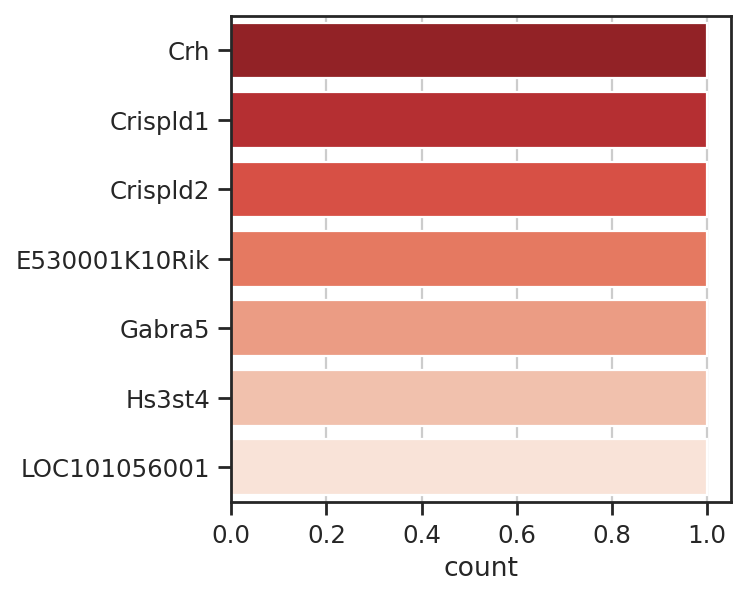

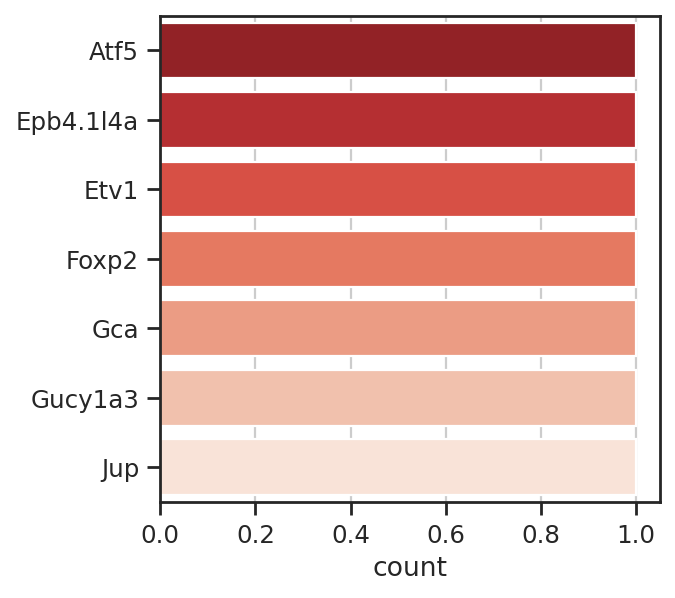

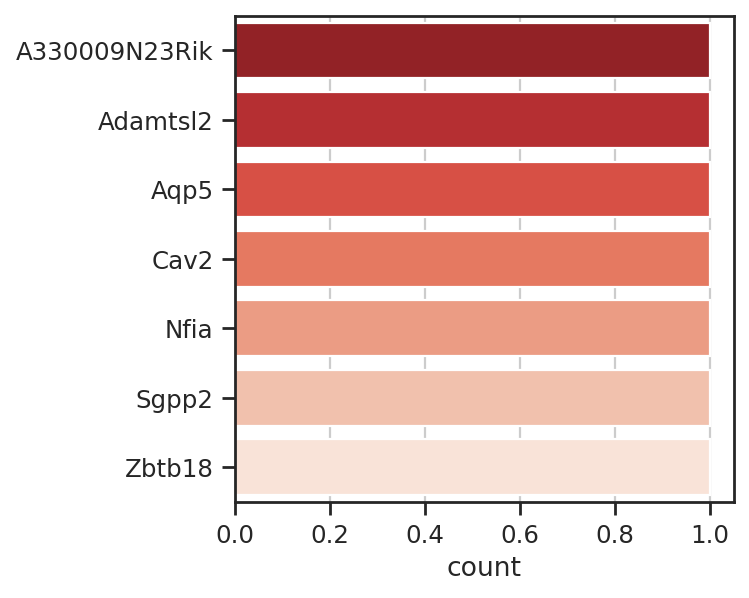

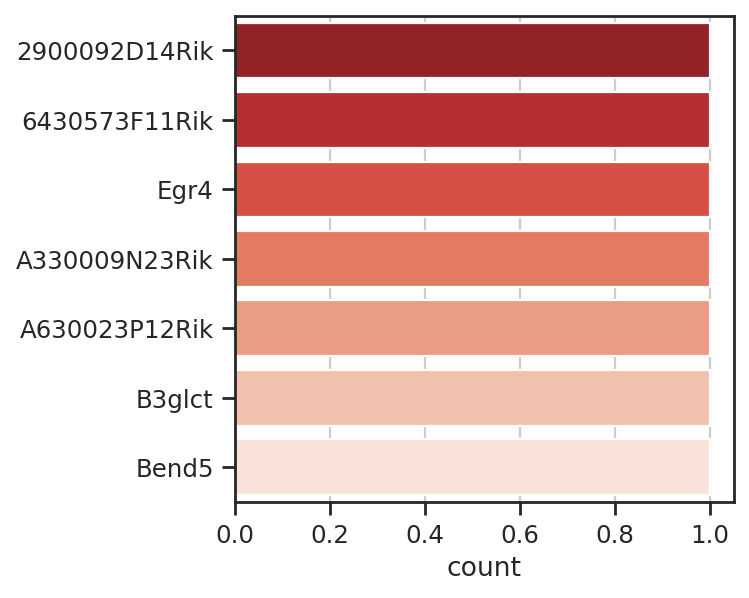

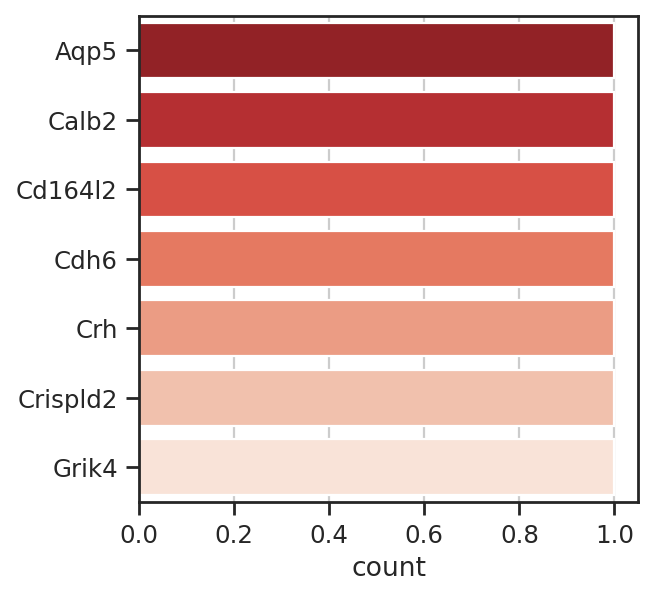

In [ ]:
sub_numers = {'Lamp5':2, 'Pvalb':5, 'Sncg':2, 'Sst':13, 'Vip':5}
for ct in ['Lamp5', 'Pvalb', 'Sncg', 'Sst', 'Vip']:
    fig,ax = plt.subplots(figsize=[4,4])
    ct_ct = pd.DataFrame(t_feature[ct])['feature_name'].value_counts().sort_values(ascending=False)
    x_order = ct_ct.index
    sns.countplot(data = t_feature[ct],y='feature_name',order = x_order[:thres],
                  palette='Reds_r',ax=ax)
    plt.grid(axis='x')
    # plt.title(f'{ct} (merged from {sub_numers[ct]} sub types)')
    # plt.xlim([0,10.5])
    plt.savefig(f'./shap_robustness/patchseq/type_relevance_{ct}_T_v2.pdf')
    type_feature_cv['T'][ct] = ct_ct[:thres].index.to_numpy()
    #type_feature_cv['T'][ct] = ct_ct[ct_ct.values>=thres].index.to_numpy()

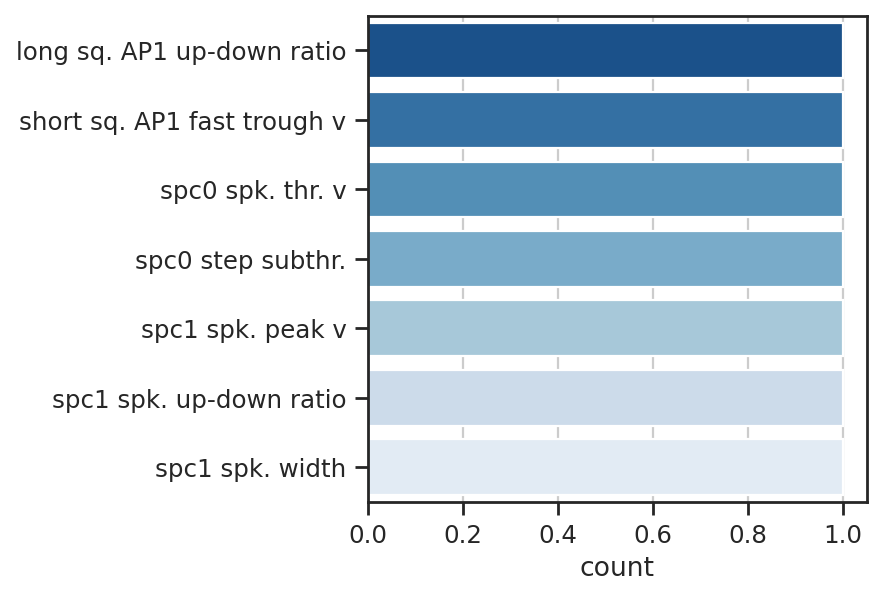

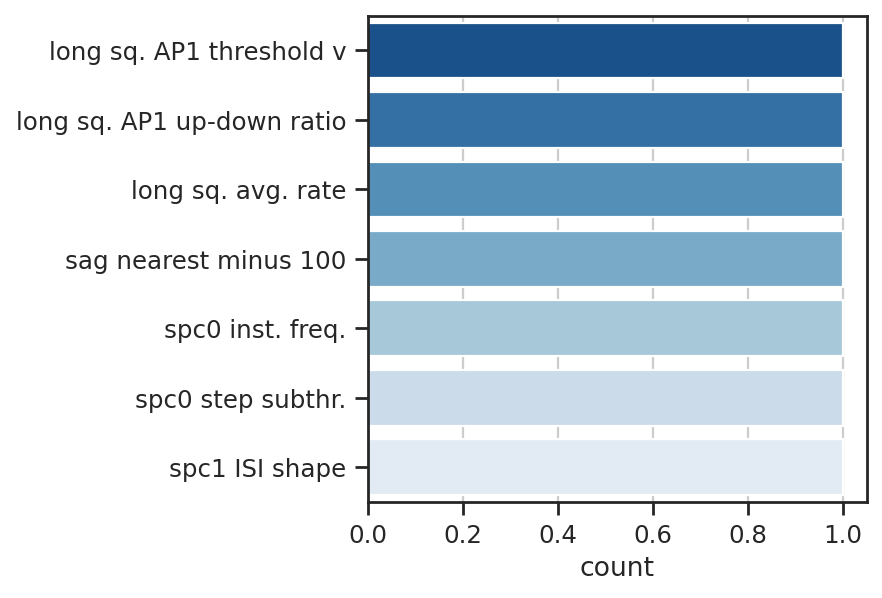

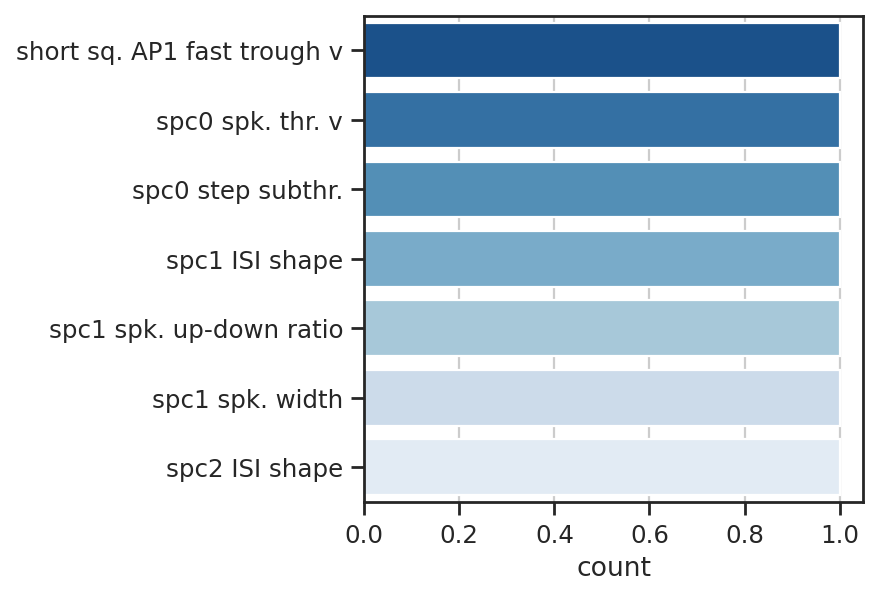

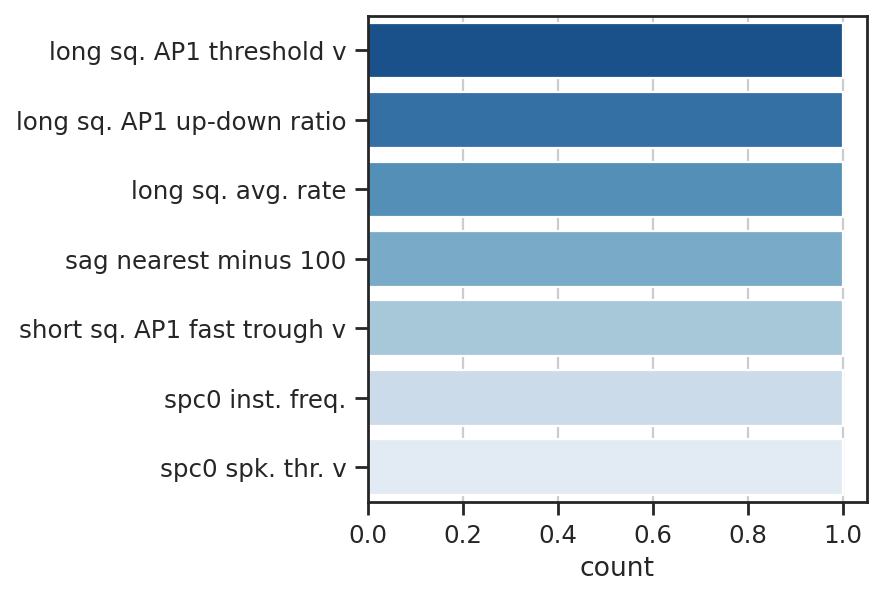

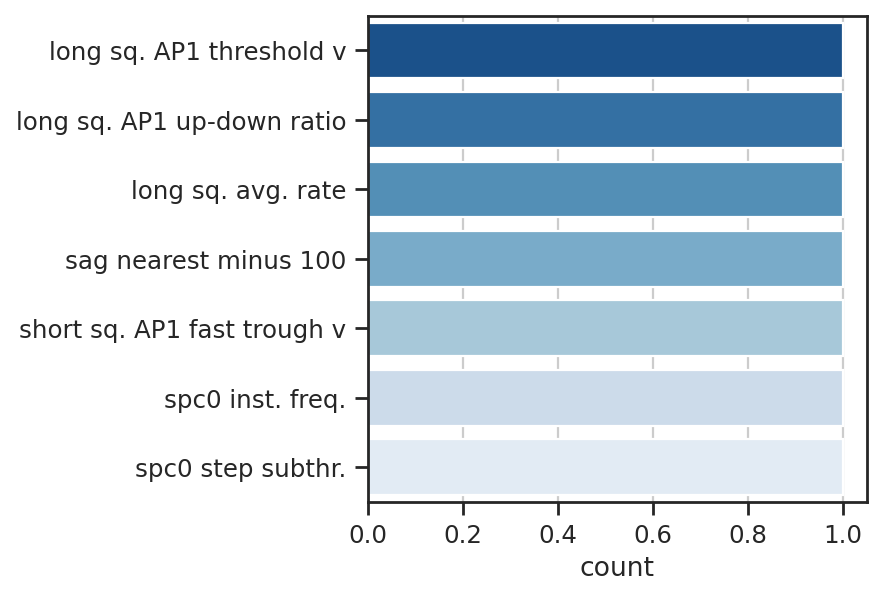

In [ ]:
for ct in ['Lamp5', 'Pvalb', 'Sncg', 'Sst', 'Vip']:
    fig,ax = plt.subplots(figsize=[4,4])
    ct_ct = pd.DataFrame(e_feature[ct])['feature_name'].value_counts().sort_values(ascending=False)
    x_order = ct_ct.index
    sns.countplot(data = e_feature[ct],y='feature_name',order = x_order[:thres],
                  palette='Blues_r',ax=ax)
    plt.grid(axis='x')
    # plt.title(ct)
    # plt.xlim([0,10.5])
    plt.savefig(f'./shap_robustness/patchseq/type_relevance_{ct}_E_v2.pdf')
    type_feature_cv['E'][ct] = ct_ct[:thres].index.to_numpy()
    #type_feature_cv['E'][ct] = ct_ct[ct_ct.values>=thres].index.to_numpy()

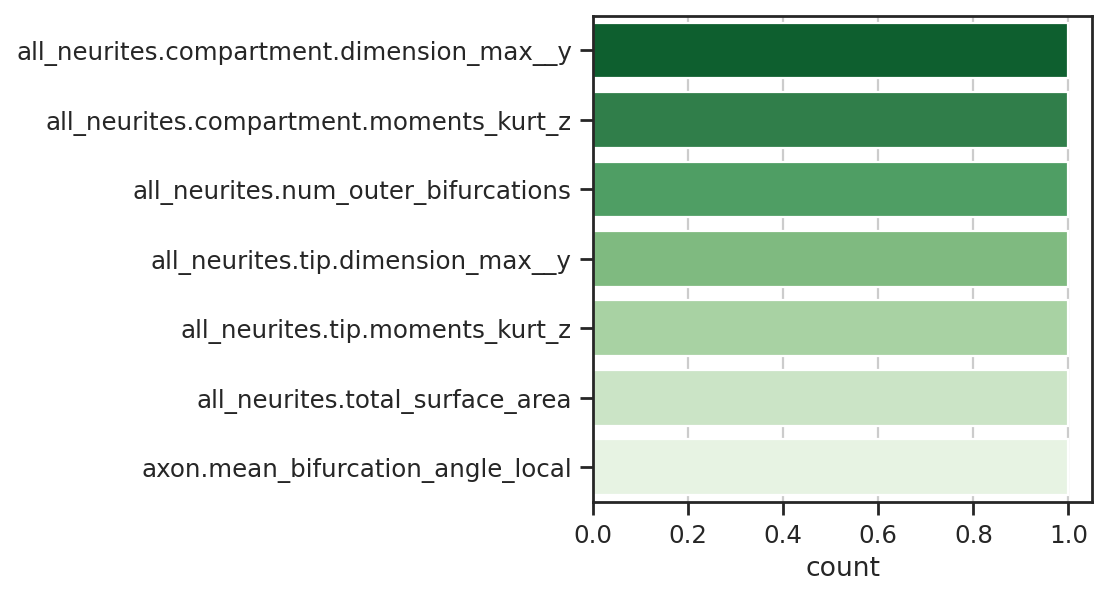

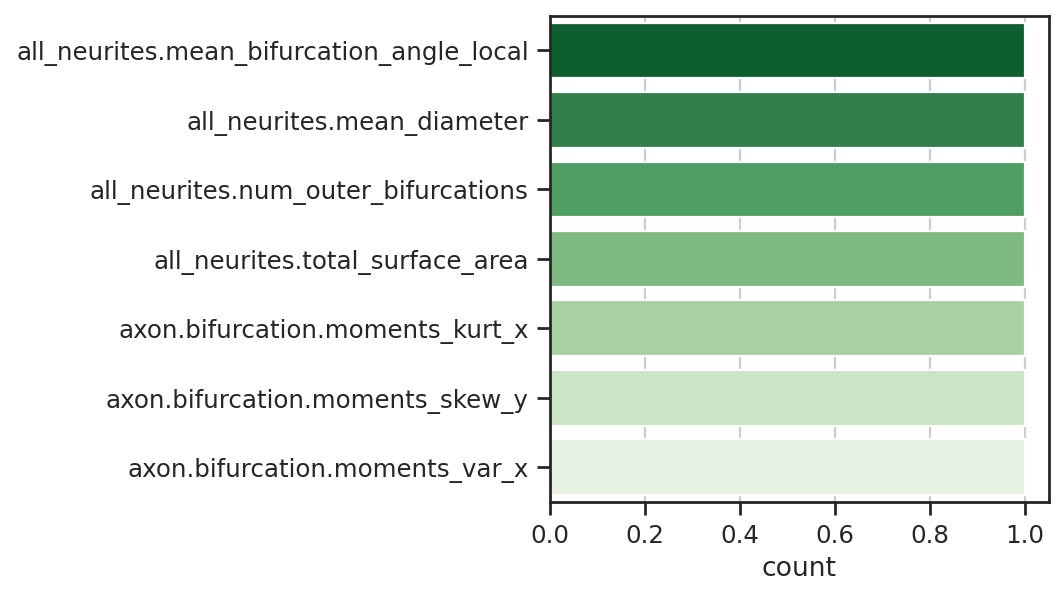

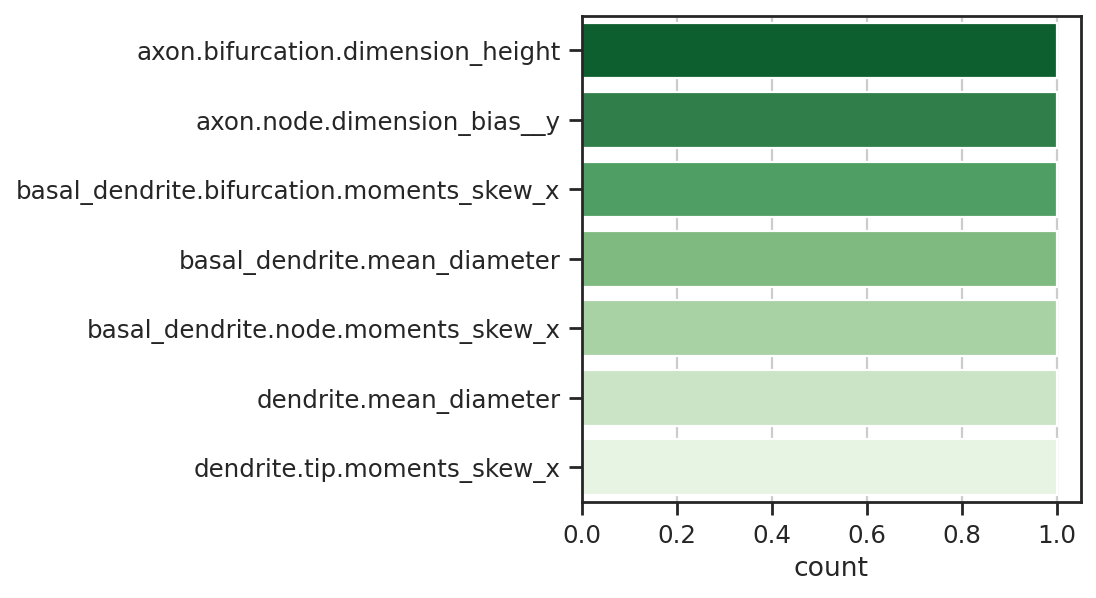

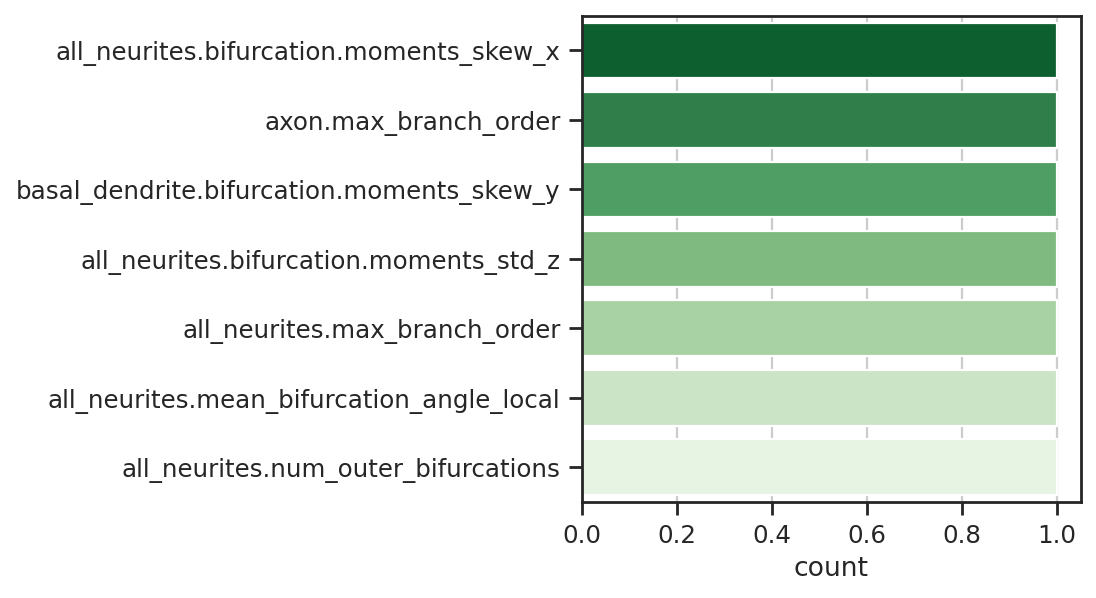

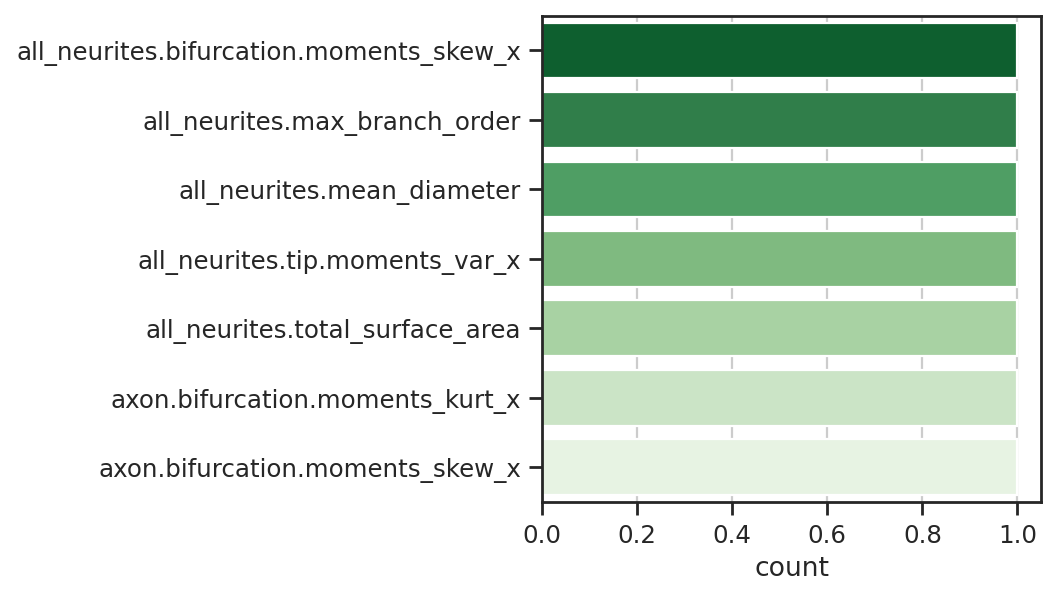

In [ ]:

for ct in ['Lamp5', 'Pvalb', 'Sncg', 'Sst', 'Vip']:
    fig,ax = plt.subplots(figsize=[4,4])
    ct_ct = pd.DataFrame(m_feature[ct])['feature_name'].value_counts().sort_values(ascending=False)
    x_order = ct_ct.index
    sns.countplot(data = m_feature[ct],y='feature_name',order = x_order[:thres],
                  palette='Greens_r',ax=ax)
    plt.grid(axis='x')
    # plt.title(ct)
    # plt.xlim([0,10.5])
    plt.savefig(f'./shap_robustness/patchseq/type_relevance_{ct}_M_v2.pdf')
    type_feature_cv['M'][ct] = ct_ct[:thres].index.to_numpy()
    # type_feature_cv['M'][ct] = ct_ct[ct_ct.values>=thres].index.to_numpy()

# Cross validated type-feature relevance plot

In [ ]:
type_feature_shap_avg = []
for ct in range(27):
    ct_vl = []
    for mod in range(3):
        ct_mod_vl = []
        #===========uncomment "for cv in range(10):" and comment "for cv in range(0):" if 
        #there are 10 iterations (namely, if cv == 1: break is commented in the previous codes block)===================
        #for cv in range(10):  
        for cv in range(1):  
            ct_mod_vl.append(type_feature_shap_values[cv][ct][mod])
        ct_vl.append(np.mean(ct_mod_vl,axis=0))
    type_feature_shap_avg.append(ct_vl)



In [ ]:
for cv in range(1):
    print(f'++++++++++++++ the current cv is {cv} ++++++++++++++')
    root_save_path = f"./saved_results/{technique}_{cv}"
    model = UnitedNet(root_save_path, device=device, technique=patchseq_config)
    _,_,adatas_all = patch_seq_pre_ps(adata_rna_raw,adata_ephys_raw,adata_morph_raw,cv,ind_dict,split=False)

    model.load_model(f"{root_save_path}/train_best.pt",device=device)
    model.model.device_in_use = device
    losses = model.evaluate(adatas_all,give_losses=True,stage='train')
    predict_label = model.predict_label(adatas_all)
    adata_fused = model.infer(adatas_all)
    adata_fused.obs['label'] = list(adatas_all[0].obs['label'])
    adata_fused.obs['label_less'] = [ct.split('-')[0] for ct in adata_fused.obs['label'].values]


    pseudo_label = np.array(adata_fused.obs['predicted_label'].values)
    cmat = confusion_matrix(adata_fused.obs['label'], pseudo_label)
    ri, ci = linear_sum_assignment(-cmat)
    ordered_all = cmat[np.ix_(ri, ci)]
    major_sub_names = {}
    pred_labels_re_order = copy.deepcopy(pseudo_label)
    lb_cor_dict = {}
    for re_oder,(lb_correct,lb) in enumerate(zip(unique_labels(adata_fused.obs['label'], pseudo_label)[ri],
                                    unique_labels(adata_fused.obs['label'], pseudo_label)[ci])):
      idx = pseudo_label==lb
      if any(idx):
        nm = '-'.join(lb_correct.split('-')[:-1])
        if nm in major_sub_names.keys():
          major_sub_names[nm]+=1
        else:
          major_sub_names[nm]=1
        lb_cor_dict[lb]=lb_correct
        pred_labels_re_order[idx] = f'{nm}-{major_sub_names[nm]}-Uni'#f'{lb_correct}-Uni'#
        

    adata_fused.obs['predicted_label'] = pred_labels_re_order
    adata_fused.obs['predicted_label_less'] = [ct.split('-')[0] for ct in adata_fused.obs['predicted_label'].values]

    accuracy_matching.append([adjusted_rand_score(adata_fused.obs['label_less'], adata_fused.obs['predicted_label_less']),adjusted_rand_score(adata_fused.obs['label'], adata_fused.obs['predicted_label'])])


++++++++++++++ the current cv is 0 ++++++++++++++


In [ ]:
predict_label_sub = [ct.split('-')[0] for ct in adatas_all[0].obs['label']]

major_dict = dict(zip(adata_fused.obs['predicted_label'].values,adata_fused.obs['predicted_label_less'].values))
predict_label_anno = pred_labels_re_order


adatas_all_new,_,_,p_l_less,pr_ty_dict = markers_chord_plot(adatas_all,predict_label,predict_label_anno,major_dict)

# ct = 'Pvalb'
for ct in np.unique(p_l_less):
    p_fe = [type_feature_cv[mod][ct] for mod in ['T','E','M']]
    p_fe_idx = [np.in1d(adatas_all[i].var_names, p_fe[i]) for i in range(3)]


    all_less_type = [ct]#

    if 'predicted_label_colors' not in adata_fused.uns.keys():
        sc.pl.umap(adata_fused,color=['predicted_label'],palette='rainbow',show=False,title='')
    colors_type = dict(zip(adata_fused.obs['predicted_label'].cat.categories,adata_fused.uns['predicted_label_colors']))
    all_type_features = type_relevance_chord_plot(type_feature_shap_avg, p_fe, p_fe_idx, p_l_less,predict_label, colors_type, all_less_type,f'{technique}_{ct}_v3',
                                  pr_ty_dict,thres=0.0,only_show_good=True, linewidth=1, linecolormap='Reds', node_width=5,
                                  potential_coloarmaps=['spring', 'summer', 'winter', 'autumn'])



Output hidden; open in https://colab.research.google.com to view.

# load the average feature-to-feature relevance

In [ ]:
feature_feature_shap_avg = {'0to1':[], '0to2':[]}
for f01 in range(68):
    f01_list = []
    #===========uncomment "for cv in range(10):" and comment "for cv in range(0):" if 
    #there are 10 iterations (namely, if cv == 1: break is commented in the previous codes block)===================
    #for cv in range(10):  
    for cv in range(1):
        f01_list.append(feature_relevance[cv]['0to1'][f01])
    feature_feature_shap_avg['0to1'].append(np.mean(f01_list,axis=0))
  

for f01 in range(514):
    f01_list = []
    #===========uncomment "for cv in range(10):" and comment "for cv in range(0):" if 
    #there are 10 iterations (namely, if cv == 1: break is commented in the previous codes block)===================
    #for cv in range(10):  
    for cv in range(1):
        f01_list.append(feature_relevance[cv]['0to2'][f01])
    feature_feature_shap_avg['0to2'].append(np.mean(f01_list,axis=0))



In [ ]:
type_feature_cv_reorder = {}
for mod_idx, mod_nm in enumerate(type_feature_cv.keys()):
  for ctp in type_feature_cv[mod_nm].keys():
    if ctp not in type_feature_cv_reorder.keys():
      type_feature_cv_reorder[ctp] = {}
    type_feature_cv_reorder[ctp][mod_idx] = type_feature_cv[mod_nm][ctp]


In [ ]:

unique_ct = list(type_feature_cv_reorder.keys())

var_names_all = [ad.var_names.values for ad in adatas_all[:2]]
c_v_values_01, io_names_01 = feature_relevance_chord_plot(feature_feature_shap_avg['0to1'],unique_ct,var_names_all,type_feature_cv_reorder,f'{technique}_cv_{cv}_average_v3',in_mod = 0,thres = None,
                                potential_coloarmaps=['spring', 'summer', 'winter', 'autumn'])

var_names_all = [ad.var_names.values for ad in adatas_all[::2]]
c_v_values_02, io_names_02 = feature_relevance_chord_plot(feature_feature_shap_avg['0to2'],unique_ct,var_names_all,type_feature_cv_reorder,f'{technique}_cv_{cv}_average_v3',in_mod = 0,thres = None,
                            direction = '0to2',potential_coloarmaps=['spring', 'summer', 'winter', 'autumn'])




Output hidden; open in https://colab.research.google.com to view.